📝 Introduction

In this project, I am working with the Wine Quality dataset to perform a binary classification task (quality ≥ 7 as good wine = 1, otherwise = 0).

I started by applying the K-Nearest Neighbors (KNN) algorithm, tuning its hyperparameters (number of neighbors, distance metrics, weighting schemes) and balancing the dataset using techniques such as SMOTE and SMOTE-Tomek.

While KNN provided reasonable results for the majority class (class 0), its performance on the minority class (class 1) was not satisfactory. This is expected, since KNN is sensitive to class imbalance and noisy decision boundaries.

To further improve the model, I plan to experiment with other machine learning algorithms such as:

Logistic Regression (baseline and interpretable)

Random Forest / Gradient Boosting (XGBoost) for handling imbalance and non-linearity

Support Vector Machines (SVM) with class weights

Ensemble methods to combine strengths of multiple models

The goal is to compare these algorithms and evaluate them using confusion matrix, ROC-AUC, precision-recall curves, and other relevant metrics, in order to select the best-performing model for this dataset.

In [1]:

#Importing necessary packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree, KDTree, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score


In [2]:
#Loading the wine datesaet from above url with separator

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.shape

(1599, 12)

In [5]:
df.isna().sum() # No null

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [6]:
# Doing a Binary classification where  quality >= 7 → good (1 else not good (0) and making it boolean
df["quality_label"] = (df["quality"] >= 7).astype(int)

In [48]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [7]:
#Dropping target column and the redundant quality column mapped to binary class
X = df.drop(columns=["quality", "quality_label"])
y = df["quality_label"]

In [8]:
print("Data shape:", X.shape)
print("Class balance:\n", y.value_counts())

#data shape and class shape


Data shape: (1599, 11)
Class balance:
 quality_label
0    1382
1     217
Name: count, dtype: int64


In [9]:
#Doing train test split with stratified class to maintain proportionality

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# doing scaling later to avoid data leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
#Trying Smote as the dataset is highly imbalanced oversampling minority class

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

sm = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train)


In [12]:
 y_train_balanced.value_counts() #seeing the balance

,count
quality_label,
0,1101
1,1101


In [55]:
X_train_balanced.shape, y_train_balanced.shape

((2202, 11), (2202,))

In [40]:
# Doing a list comprehension and then a for loop with hyperparameters

# k is nearest neigbours to search

params = [(k, algo) for k in [3, 5, 7] for algo in ['ball_tree', 'kd_tree']] # ball tree and kd tree different ways of seraching nearest neighbours
results = []

for k, algo in params:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm=algo)
    knn.fit(X_train_balanced, y_train_balanced )
    acc = knn.score(X_test_scaled, y_test)
    results.append(((k, algo), acc))


In [56]:
# Picking the best model from tuple
best_params, best_score = max(results, key=lambda x: x[1]) # from the second element of tuple
print(f"Best params: k={best_params[0]}, algorithm={best_params[1]}, accuracy={best_score:.3f}")

Best params: k=3, algorithm=ball_tree, accuracy=0.838


In [13]:

#doing another Hyperparameter Search (K, distance metric, weights) which gave better results
best_acc = 0 #Initializing
best_params = None

for k in range(1, 21):  # Trying  K = 1 to 20 nearest neighbours
    for w in ['uniform', 'distance']:  #  uniform all have same voting weight, Distance close neighbours more weightage
        for p in [1, 2]:  # Manhattan vs Euclidean l1 and L2
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, p=p)
            knn.fit(X_train_balanced, y_train_balanced)
            acc = knn.score(X_test_scaled, y_test)

            if acc > best_acc:
                best_acc = acc
                best_params = (k, w, p)

print(f"Best Params: K={best_params[0]}, Weights={best_params[1]}, p={best_params[2]}, Accuracy={best_acc:.4f}")


Best Params: K=2, Weights=uniform, p=1, Accuracy=0.8938


In [14]:
#unpacking best parameters


best_k, best_w, best_p = best_params

In [ ]:
final_knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_w, p=best_p)
final_knn.fit(X_train_balanced, y_train_balanced)

In [16]:
# Making  predictions on test set
y_pred = final_knn.predict(X_test_scaled)
y_prob = final_knn.predict_proba(X_test_scaled)[:,1]   # for ROC/PR curves we needground truth and predict proba

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
#Importing necesaary packages for evaluation

In [18]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       277
           1       0.59      0.67      0.63        43

    accuracy                           0.89       320
   macro avg       0.77      0.80      0.78       320
weighted avg       0.90      0.89      0.90       320



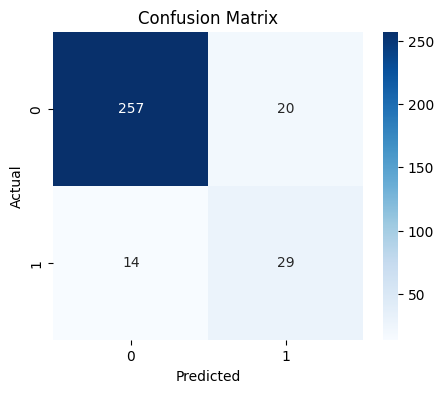

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


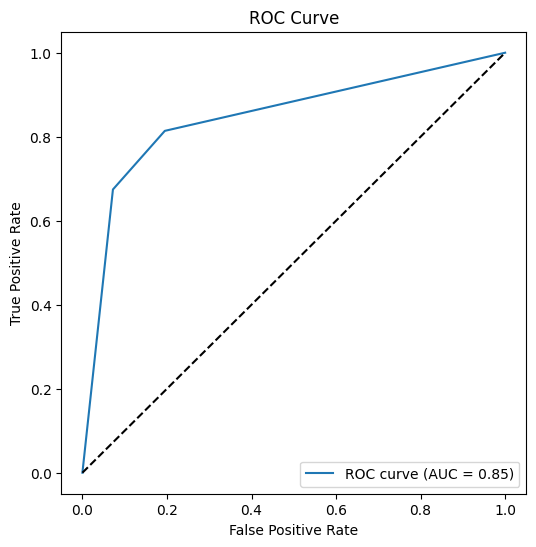

In [24]:
# ROC Curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

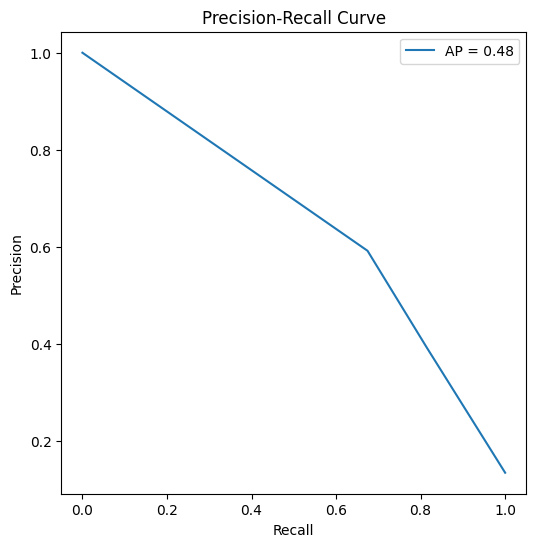

In [25]:
#precision recall curve as dataset is highly imbalanced

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()